In [1]:
# Import Package
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
import os
import random
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.feature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import matplotlib.colors as colors
import cartopy.feature as cfeature
import pandas as pd
from scipy.stats import norm
from scipy.stats import laplace
import matplotlib as mpl
from scipy import stats
import os
from scipy import optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import contextily as ctx
import math

import xarray as xr

## How to extract the trans-urban wind path


### read example data


In [2]:
import numpy as np
# load example data (these datasets are all resample in 0.1 degree)
# read landuse mask array
ar_urban = np.loadtxt(r"example/urban_mask.txt")

# read ERA5 u and v wind array
ar_u = np.loadtxt(r"example/u_wind.txt")
ar_v = np.loadtxt(r"example/v_wind.txt")

# read IMERG rainfall array
ar_precip = np.loadtxt(r"example/pre.txt")


### Display the example data

```python

```


C:\Users\32952\AppData\Local\Temp\ipykernel_98020\2114979130.py:30: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 7 Axes> than <Figure size 2000x2000 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(rs, orientation="horizontal", fraction=0.1, pad=0.1, aspect=40, shrink=0.7)


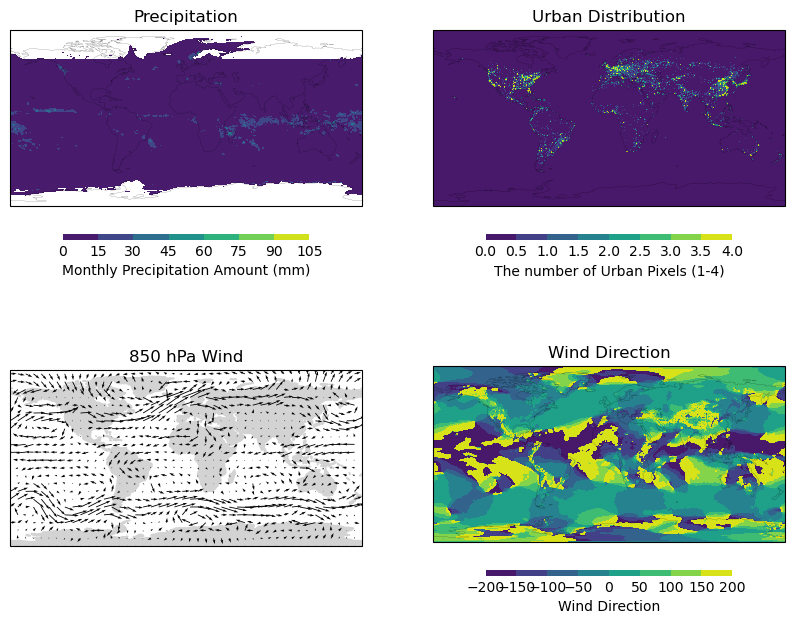

<Figure size 2000x2000 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import numpy as np

# as we mentioned in our paper, the direction is calculated by the arctan(U/V)
def calculate_angle1(x, y):
    angle_rad = math.atan2(y, x)
    angle_deg = math.degrees(angle_rad)
    return angle_deg

# calculate the wind direction for our example data
wind_direction = np.zeros([1800,3600])
for i in range(1800):
    for j in range(3600):
        wind_direction[i,j] = calculate_angle1(ar_u[i,j],ar_v[i,j])

# the script for displaying the array with color
def arraytofig_01(ax,array, title, cbar_label, set_range=[-180, 180, -90, 90]):
    olon = np.linspace(-180, 180, 3600)
    olat = np.linspace(-90, 90, 1800)
    olon, olat = np.meshgrid(olon, olat)
    testarray = array.copy()
    testarray[testarray == -9999] = np.nan
    
    ax.set_extent(set_range, crs=ccrs.PlateCarree())
    ax.set_title(title)
    rs = ax.contourf(olon, olat, testarray, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, lw=0.1)
    cbar = plt.colorbar(rs, orientation="horizontal", fraction=0.1, pad=0.1, aspect=40, shrink=0.7)
    ax2 = cbar.ax
    ax2.tick_params(left=False, right=False, bottom=False, pad=-0.5)
    cbar.outline.set_visible(False)
    cbar.set_label(cbar_label)
    return ax

# the script for displaying the wind pattern
def towindfig(ax,uwind, vwind, title, set_range=[-180, 180, -90, 90]):
    olon = np.linspace(-180, 180, len(uwind[1]))
    olat = np.linspace(-90, 90, len(uwind[:, 1]))
    olon, olat = np.meshgrid(olon, olat)
    ax.set_extent(set_range, crs=ccrs.PlateCarree())
    ax.set_title(title)
    ax.add_feature(cfeature.LAND, color="lightgrey")
    cq = ax.quiver(
        olon[::80, ::80],
        olat[::80, ::80],
        uwind[::80, ::80],
        vwind[::80, ::80],
        color="k",
        transform=ccrs.PlateCarree(),
    )
    return ax

# Create a figure with two subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Show the spatial pattern of data for Precipitation and Urban distribution
axs[0,0] = arraytofig_01(axs[0,0],ar_precip, "Precipitation", "Monthly Precipitation Amount (mm)")
axs[0,1] = arraytofig_01(axs[0,1],ar_urban, "Urban Distribution", "The number of Urban Pixels (0-4)")
axs[1,0] = towindfig(axs[1,0],ar_u,ar_v,"850 hPa Wind")
axs[1,1] = arraytofig_01(axs[1,1],wind_direction,"Wind Direction","Wind Direction")
# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### How to search the downwind or upwind pixels of each pixel

In [36]:
# To avoid the repeated operation, this list is used to record the location of urban pixels.
#  If the looped urban pixels is in this list, Skip!!!


# search the downwind pixel based on the wind direction
def downwind_pixel(location, wind_direction):
    [i, j] = location
    if wind_direction < -157.5:
        j = j - 1
    elif wind_direction < -112.5:
        j = j - 1
        i = i - 1
    elif wind_direction < -67.5:
        i = i - 1
    elif wind_direction < -22.5:
        j = j + 1
        i = i - 1
    elif wind_direction < 22.5:
        j = j + 1
    elif wind_direction < 67.5:
        j = j + 1
        i = i + 1
    elif wind_direction < 112.5:
        i = i + 1
    elif wind_direction < 157.5:
        i = i + 1
        j = j - 1
    else:
        j = j - 1
    return [i, j]


def upwind_pixel(location, wind_direction):
    [i, j] = location
    if wind_direction < -157.5:
        j = j + 1
    elif wind_direction < -112.5:
        j = j + 1
        i = i + 1
    elif wind_direction < -67.5:
        i = i + 1
    elif wind_direction < -22.5:
        j = j - 1
        i = i + 1
    elif wind_direction < 22.5:
        j = j - 1
    elif wind_direction < 67.5:
        j = j - 1
        i = i - 1
    elif wind_direction < 112.5:
        i = i - 1
    elif wind_direction < 157.5:
        i = i - 1
        j = j + 1
    else:
        j = j + 1
    return [i, j]




### How to extract the wind path

In [38]:
def get_wind_path(wind_direction):
    urbanlist = []
    dict_wind_path = {
        "lat": [],
        "lon": [],
        "dem": [],
        "urban": [],
        "pre": [],
    }
    for row in range(1800):
        for col in range(3600):
            if ar_urban[row, col] > 0:
                if [row, col] not in urbanlist:
                    urbanlist.append([row, col])
                    # Here we search a new urban pixel

                    # define the precipitation amount among the wind path
                    pre_up = []
                    pre_down = []

                    # define the terrain height among the wind path
                    dem_up = []
                    dem_down = []

                    # define urban pixels among the wind path
                    urban_down = []
                    urban_up = []

                    # define the locations among the wind path
                    lat_up = []
                    lat_down = []
                    lon_up = []
                    lon_down = []

                    [i, j] = [row, col]

                    # define the range far from the urban pixels
                    num = 0

                    # num refers to the range of downwind area (0.3 degree = 3 pixels)
                    # search downwind pixels
                    while num < 3:
                        [i, j] = downwind_pixel([i, j], wind_direction[i, j])
                        # IF i or j is greater than or less than the boundary, skip
                        if j > 3599 or j < 0 or i > 1799 or i < 0:
                            num = 6
                        # IF [i,j] is still the boundary, Then search next pixels
                        else:
                            if ar_urban[i, j] > 0:
                                if [i, j] in urbanlist:
                                    num = 5
                                else:
                                    num = 0
                                    pre_down.append(ar_precip[i, j])
                                    urbanlist.append([i, j])
                                    urban_down.append(1)
                                    lat_down.append(i)
                                    lon_down.append(j)
                            else:
                                num += 1
                                urbanlist.append([i, j])
                                pre_down.append(ar_precip[i, j])
                                urban_down.append(0)
                                lat_down.append(i)
                                lon_down.append(j)

                    if num < 5:
                        [i, j] = [row, col]
                        num = 0
                        while num < 3:
                            [i, j] = upwind_pixel([i, j], wind_direction[i, j])
                            # IF i or j is greater than or less than the boundary, skip
                            if j > 3599 or j < 0 or i > 1799 or i < 0:
                                num = 5
                            # IF [i,j] is still the boundary, Then search next pixels
                            else:
                                if ar_urban[i, j] > 0:
                                    if [i, j] in urbanlist:
                                        num = 5
                                    else:
                                        num = 0
                                        pre_up.append(ar_precip[i, j])
                                        urbanlist.append([i, j])
                                        urban_up.append(1)
                                        lat_up.append(i)
                                        lon_up.append(j)
                                else:
                                    num += 1
                                    urbanlist.append([i, j])
                                    pre_up.append(ar_precip[i, j])
                                    urban_up.append(0)
                                    lat_up.append(i)
                                    lon_up.append(j)

                    if num == 5:
                        pass
                    else:
                        prelist = pre_up[::-1] + [ar_precip[row, col]] + pre_down
                        urbantotal = urban_up[::-1] + [1] + urban_down
                        pos_lat_list = lat_up[::-1] + [row] + lat_down
                        pos_lon_list = lon_up[::-1] + [col] + lon_down

                        dict_wind_path["lat"].append(pos_lat_list)
                        dict_wind_path["lon"].append(pos_lon_list)
                        dict_wind_path["urban"].append(urbantotal)

                        dict_wind_path["pre"].append(prelist)
    return dict_wind_path


dict_wind_path = get_wind_path(wind_direction)

### Display the wind path here

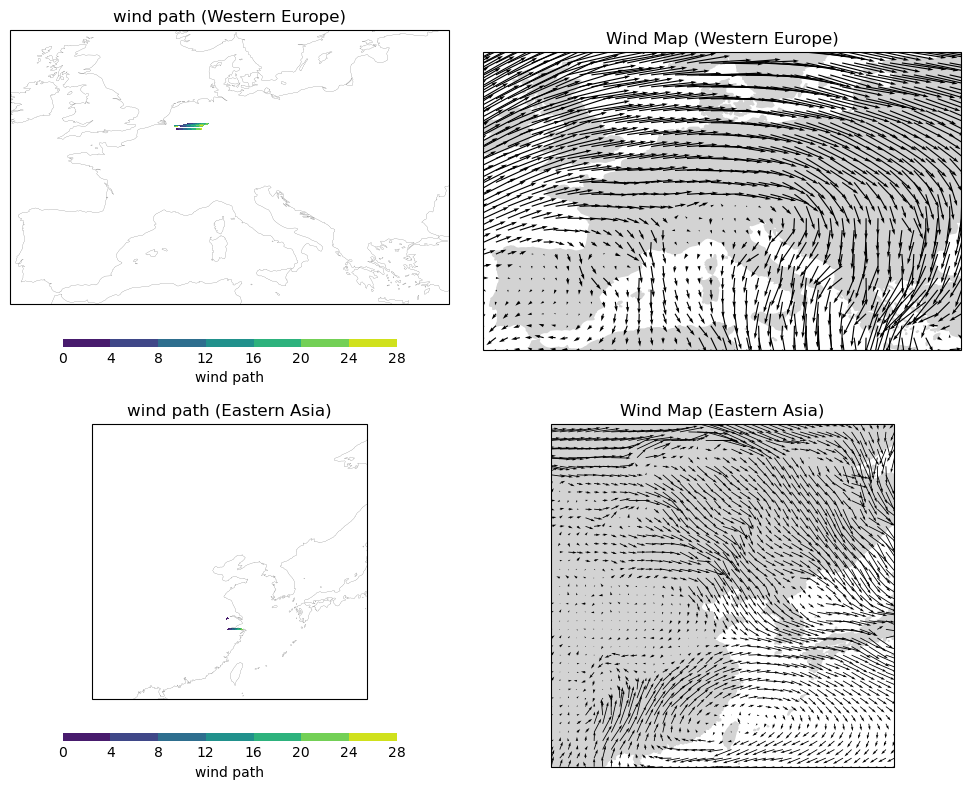

In [49]:
# show some wind path in our result
wind_path_array = np.zeros([1800, 3600])
for lons, lats in zip(dict_wind_path["lon"], dict_wind_path["lat"]):
    i = 0
    if len(lons) > 20:
        for i in range(len(lons)):
            wind_path_array[lats[i], lons[i]] = i + 1
            i += 1



# the script for displaying the wind pattern
def towindfig(ax,uwind, vwind, title, set_range=[-180, 180, -90, 90]):
    olon = np.linspace(-180, 180, len(uwind[1]))
    olat = np.linspace(-90, 90, len(uwind[:, 1]))
    olon, olat = np.meshgrid(olon, olat)
    ax.set_extent(set_range, crs=ccrs.PlateCarree())
    ax.set_title(title)
    ax.add_feature(cfeature.LAND, color="lightgrey")
    cq = ax.quiver(
        olon[::10, ::10],
        olat[::10, ::10],
        uwind[::10, ::10],
        vwind[::10, ::10],
        color="k",scale=160,
        transform=ccrs.PlateCarree(),
    )
    return ax

# Create a figure with two subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
wind_path_array[wind_path_array==0] = np.nan
# Show the spatial pattern of data for Precipitation and Urban distribution
axs[0,0] = arraytofig_01(axs[0,0],wind_path_array, "wind path (Western Europe)", "wind path", [-10, 30, 35, 60])
axs[0,1] = towindfig(axs[0,1],ar_u, ar_v, "Wind Map (Western Europe)", [-10, 30, 35, 60])
axs[1,0] = arraytofig_01(axs[1,0],wind_path_array, "wind path (Eastern Asia)", "wind path", [100, 140, 20, 60])
axs[1,1] = towindfig(axs[1,1],ar_u, ar_v, "Wind Map (Eastern Asia)", [100, 140, 20, 60])
# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### how to standardize the urban part of each wind path to a uniform width (0.3 degrees) 

In [52]:
# There are 9 intervals in line chart. (three intervals for upwind area,
# three intervals for urban area and three intervals for downwind area)

up1, up2, up3 = [], [], []
urban1, urban2, urban3 = [], [], []
down1, down2, down3 = [], [], []

# We only analyze the large cities
for pres, urbans in zip(dict_wind_path["pre"], dict_wind_path["urban"]):
    if np.sum(urbans) >= 12:
        if -9999 not in pres:

            # The first (last) three are non-urban pixels
            # But non-urban and urban pixels are both in the middle
            # Here we extract the urban pixels
            urban_length = 0
            urban_pre = []
            x = []
            for i in range(len(urbans)):
                if urbans[i] == 1:
                    urban_pre.append(pres[i])
                    x.append(urban_length)
                    urban_length += 1
            # Done!!!

            # Standardize the urban width to a consistent length (3 pixels)
            maxnum = len(x) + 1
            # Here the add_list1 can make [1,2,3,....,n-2,n-1,n] to [1,2,3,...,7,8,9]
            add_list1 = [(xx + 1) / maxnum * 4 + 3 for xx in x]
            x = [1, 2, 3] + add_list1 + [7, 8, 9]

            y = pres[:3] + urban_pre + pres[-3:]
            # I will test this code later, Please check!

            # Standardize the precipitation amount (0 to 1)
            maxx = np.max(y)
            minn = np.min(y)
            y = (y - minn) / (maxx - minn)

            # Collect the rainfall amount in the upwind and downwind area
            for baby in range(len(x)):
                if x[baby] == 1:
                    up1.append(y[baby])
                elif x[baby] == 2:
                    up2.append(y[baby])
                elif x[baby] == 3:
                    up3.append(y[baby])
                elif x[baby] == 7:
                    down1.append(y[baby])
                elif x[baby] == 8:
                    down2.append(y[baby])
                elif x[baby] == 9:
                    down3.append(y[baby])

                # make 3 intervals in [3,7] range
                elif x[baby] < 3 + 4 / 3:
                    urban1.append(y[baby])
                elif x[baby] < 3 + 4 / 3 * 2:
                    urban2.append(y[baby])
                elif x[baby] < 3 + 4 / 3 * 3:
                    urban3.append(y[baby])

### plot the precipitation on the standardized wind path

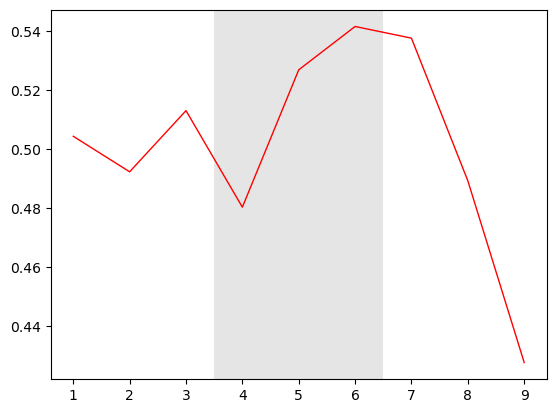

In [53]:
plt.plot(
    [1, 2, 3, 4, 5, 6, 7, 8, 9],
    [
        np.mean(up1),
        np.mean(up2),
        np.mean(up3),
        np.mean(urban1),
        np.mean(urban2),
        np.mean(urban3),
        np.mean(down1),
        np.mean(down2),
        np.mean(down3),
    ],
    color="red",
    linewidth=1,
)
plt.axvspan(3.5, 6.5, facecolor="grey", alpha=0.2)

## the bootstrape method to calculate 95% confidence area

In [54]:
def bootstrap_mean_ci(data, confidence=0.95, n_bootstrap=10000):
    boot_means = np.random.choice(data, (n_bootstrap, len(data)), replace=True).mean(axis=1)
    lower_bound = np.percentile(boot_means, (1 - confidence) / 2 * 100)
    upper_bound = np.percentile(boot_means, (1 + confidence) / 2 * 100)
    return upper_bound,lower_bound